In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from numpy.polynomial.polynomial import polyval2d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

## Regressor Implementations

In [2]:
from abc import ABC, abstractmethod
import metric
import numpy as np
from sklearn.model_selection import train_test_split
from collections import deque  # fixed size FIFO queue
import types

class LinearModel(ABC):
    def __init__(self):
        self.params = None

    @abstractmethod
    def fit(self, X, y):
        pass

    def predict(self, X):
        return X @ self.params

    def score(self, X, y):
        model = self.predict(X)
        mean = np.mean(model)
        sq_error = np.dot(y - model, y - model)
        return 1 -  sq_error / np.dot(y - mean, y - mean)


class OrdinaryLeastSquare(LinearModel):
    def __init__(self):
        super().__init__()

    def fit(self, X, y):
        self.params = np.linalg.pinv(X.T @ X) @ X.T @ y
            
class RidgeRegression(LinearModel):
    def __init__(self, penalty):
        super().__init__()
        self.penalty = penalty

    def fit(self, X, y):
        p = X.shape[-1]
        # Matrix inverse exists for all  penalities > 0 (symmetric + positive-definit)
        self.params = np.linalg.inv(X.T @ X + self.penalty*np.eye(p,p)) @ X.T @ y


class StochasticGradientDescent(LinearModel):
    def __init__(
        self,
        loss="squared_error",
        max_epochs=1000,
        batches=None,
        shuffle=True,
        seed=42,
        learning_rate=lambda t, grad: 1e-3,
        momentum=0.9,
        early_stopping=False,
        validation_fraction=0.2,
        n_iter_no_change=5,
        tol=0.001,
        verbose=False
    ):
        super().__init__()
        self.loss = loss
        self.max_epochs = max_epochs
        self.batches = batches
        self.tol = tol
        self.shuffle = shuffle
        self.seed = seed
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.verbose = verbose

    def __loss(self, X, y):
        y_pred = self.predict(X)
        if self.loss == "squared_error":
            return np.dot(y - y_pred, y - y_pred)
        if self.loss == "ridge":
            return np.dot(y - y_pred, y - y_pred) + self.penalty * np.dot(
                self.params, self.params
            )

    def __gradient_loss(self, X, y):
        y_pred = self.predict(X)
        if self.loss == "squared_error":
            return 2 * X.T @ (y_pred - y)
        if self.loss == "ridge":
            return 2 * X.T @ (y_pred - y) + 2 * self.penalty * self.params

    def fit(self, X, y):
        p = X.shape[-1]
        
        if self.shuffle:
            np.random.seed(self.seed)

        # initial parameters ~ U(0,1)
        self.params = np.random.rand(p)

        if self.batches is None:
            # Assume vanilla stochastic gradient descent
            self.batches = N

        # Do not mess with the original data
        X_train = X_test = X
        y_train = y_test = y
        
        if self.early_stopping:
            X_train, X_test, y_train, y_test = train_test_split(
               X, y, test_size=self.validation_fraction, random_state=self.seed
            )

        # Initialize the score history such that the optimization proceeds for at
        # least n_iter_no_change epochs by assuming that "past" epochs have improved
        # the score by at least a decrement of tol each. 
        score_history = deque(
           reversed([self.score(X_test, y_test) + i * self.tol for i in range(self.n_iter_no_change)]),
        self.n_iter_no_change,
        )
        param_history = deque(
           self.n_iter_no_change * [self.params],
           self.n_iter_no_change,
        )
        
        self.iteration = 0
        step = 0
        learning_rate = 0
        for epoch in range(self.max_epochs):
            # Randomize training data on each epoch
            if self.shuffle:
                mini_batches = np.arange(X_train.shape[0])
                np.random.shuffle(mini_batches)
                mini_batch_indices = np.array_split(mini_batches, self.batches)

            for t,mini_batch_idx in enumerate(mini_batch_indices):
                x_b = X_train[mini_batch_idx, :]
                y_b = y_train[mini_batch_idx]

                #Learning rate set by external user-provided policy, dependent on
                #optimization iteration and gradient.
                grad = self.__gradient_loss(x_b, y_b)
                if isinstance(self.learning_rate, types.GeneratorType):
                    next(self.learning_rate)
                    learning_rate = self.learning_rate.send(grad)
                else:
                    learning_rate = self.learning_rate(self.iteration, grad)
                
                step *= self.momentum
                step += learning_rate * grad
                
                self.params = self.params - step
                
                self.iteration += 1

            param_history.appendleft(self.params)
            score_history.appendleft(self.score(X_test,y_test))
            delta_score = score_history[0]-score_history[-1]
            if self.verbose:
                print(f"Epoch {epoch}/{self.max_epochs}\t Score: {score_history[0]}\t dScore: {delta_score}")
            
            # After each epoch we check for early convergence by computing the R2-score.
            # Notice if early_stopping=False, we use the entire training set to compute the
            # score (X_train = X_test = X)
            # Define convergence as improving R2 by less than tol over the last n_iter_no_change epochs.
            # This includes the case of decreasing R2 (delta_score < 0)  
            if delta_score < self.tol:
                # Pick best parameters within the last n_iter_no_change epochs
                self.param = param_history[np.argmax(score_history)]
                return
                
        if self.verbose:
            print("Maximum number of epochs reached.")

In [3]:
def mse(data, model):
    data = data.flatten()
    model = model.flatten()
    return 1/data.shape[0] * np.dot(data-model,data-model)

def r_score(data, model):
    data = data.flatten()
    model = model.flatten()
    mean = np.mean(model)
    return 1 - data.shape[0] * mse(data,model)/np.dot(data - mean, data - mean)

## Ordinary Least Square on Franke Function

In [4]:
def franke_function(x,y):
    return 3/4 * np.exp( -1/4*(9*x - 2)**2 - 1/4*(9*y - 2)**2 ) + \
           3/4 * np.exp( -1/49*(9*x + 1)**2 - 1/10*(9*y + 1) ) + \
           1/2 * np.exp( -1/4*(9*x - 7)**2 - 1/4*(9*y - 3)**2 ) - \
           1/5 * np.exp( -(9*x - 4)**2 - (9*y - 7)**2 )

In [5]:
def poly2d(x,y,beta):
    beta = np.asarray(beta)
    # number of features = order*(order+1)/2 (Gauss' summation formula)
    order = int((np.sqrt(8*beta.shape[0]+1)-1)/2)
    # coefficient matrix with c[i,j] corresponding to coeff for x^i y^j
    c = np.zeros((order,order))
    # translate coefficient vector into matrix  
    idx = np.tile(np.arange(order+1),  (order,1))
    offset =  np.repeat(np.arange(order), np.arange(order)+1)
    idx = idx[np.tril_indices(order)]
    idy = offset - idx
    
    c[idx, idy] = beta
    return polyval2d(x,y,c)

In [36]:
def generate_franke_data(N, order, sigma=1):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X,Y = np.meshgrid(x,y)
    
    # forming the cartesian product of x and y coordinates
    xy = np.array([X,Y]).T.reshape(-1,2)
    z = franke_function(xy[:,0], xy[:,1]) + sigma*np.random.randn(N*N)
    
    # Setup system matrix M by...
    # creating a list of multi-indices alpha with |alpha| = N
    alpha = []
    for n in range(order):
        a = np.arange(n+1)
        alpha += zip(a,n-a) 

    # taking each data point to the power of the respective multindex andforming its product
    # M is now the matrix of all possible monomials (column) for each data point (row)
    M = np.power(xy[:,np.newaxis,:],alpha)
    return np.prod(M, axis=-1), z
    

In [107]:
split = True
standardize = False

p = 5
N = 20
sigma = 0
M, z = generate_franke_data(N, p, sigma)
M_train = M_test = M

if split:
    M_train, M_test, y_train, y_test = train_test_split(M,z)

if standardize:
    scaler = StandardScaler()
    M_train = scaler.fit_transform(M_train)
    M_test = scaler.transform(M_test)

ols = OrdinaryLeastSquare()
ols.fit(M_train,y_train)

r2_score = ols.score(M_test, y_test)
mse_score = mse(y_test, ols.predict(M_test))
print(f"R2 = {r2_score}")
print(f"MSE = {mse_score}")

R2 = 0.9516016738372579
MSE = 0.003818115971516011


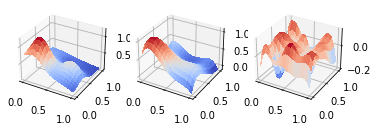

In [108]:
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
X,Y = np.meshgrid(x,y)

    
kwargs = {"lw":2, 
          "cmap":cm.coolwarm, 
          "antialiased":False}

fig = plt.figure()
ax_data = fig.add_subplot(131, projection='3d')
ax_fit = fig.add_subplot(132, projection='3d')
ax_diff = fig.add_subplot(133, projection='3d')

fXY = z.reshape(N,N).T
fit = ols.predict(M)
fit = fit.reshape(N,N).T

ax_data.plot_surface(X, Y, fXY, **kwargs)
ax_fit.plot_surface(X, Y, fit, **kwargs)
ax_diff.plot_surface(X, Y, fit-fXY, **kwargs)

plt.show()

## Model Complexity Sweep

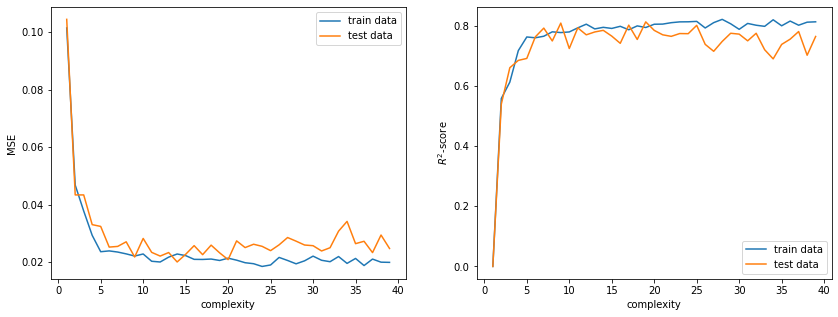

In [102]:
N = 40
sigma = 0.15
standardize = False

ols = OrdinaryLeastSquare()
complexity = np.arange(1, 40)
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for p in complexity:
    M, z = generate_franke_data(N, p, sigma)
    M_train, M_test, y_train, y_test = train_test_split(M,z,test_size=0.2)
    
    if standardize:
        scaler = StandardScaler()
        M_train = scaler.fit_transform(M_train)
        M_test = scaler.transform(M_test)
        
    ols.fit(M_train,y_train)
    
    mse_test.append(mse(y_test, ols.predict(M_test)))
    mse_train.append(mse(y_train, ols.predict(M_train)))
    
    r2_test.append(ols.score(M_test, y_test))
    r2_train.append(ols.score(M_train, y_train))
    
fig, ax = plt.subplots(ncols=2, figsize=(14,5))
ax[0].plot(complexity, mse_train, label="train data")
ax[0].plot(complexity, mse_test, label="test data")
ax[0].set(xlabel="complexity", ylabel="MSE")
ax[0].legend(*ax[0].get_legend_handles_labels())

ax[1].plot(complexity, r2_train, label="train data")
ax[1].plot(complexity, r2_test, label="test data")
ax[1].set(xlabel="complexity", ylabel=r"$R^2$-score")
ax[1].legend(*ax[1].get_legend_handles_labels())
plt.show()

## Stochastic Gradient Adaptive Learning Rates

In [91]:
def adagrad():
    # initial learning rate
    eta0 = 1e-2
    # safe-guard against divergence
    epsilon = 1e-8
    g2_t = 0
    while True:
        gradient = yield
        g2_t += gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t)
    
def rmsprop():
    # initial learning rate
    eta0 = 1e-3
    # decay constant
    beta=0.9 
    # safe-guard against divergence
    epsilon = 1e-8
    # moving average of second moment of gradient
    g2_t_avg = 0
    
    while True:
        gradient = yield
        g2_t_avg = beta*g2_t_avg + (1-beta)*gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t_avg)
        
def adam():
    # initial learning rate
    eta0 = 1e-3
    # decay constant for first moment
    beta1=0.9 
    # decay constant for second moment 
    beta2=0.999
    # safe-guard against divergence
    epsilon = 1e-8
    # moving average of second moment of gradient
    g2_t_avg = 0
    # moving average of first moment of gradient
    g_t_avg = 0
    
    while True:
        gradient = yield
        g_t_avg = beta1*g_t_avg + (1-beta1)*gradient
        g2_t_avg = beta2*g2_t_avg + (1-beta2)*gradient**2
        
        g_t_avg_corr = g_t_avg/(1-beta1**2)
        g2_t_avg_corr = g2_t_avg/(1-beta2**2)
        # divide out gradient to conform with structure of standard SGD update (see SVD class defintion)
        yield eta0 / (epsilon + np.sqrt(g2_t_avg_corr) + gradient) * g_t_avg

In [96]:
m = 1000
x = 2*np.random.rand(m,1)
y = 4+3*x+np.random.randn(m,1)

#scale = StandardScaler()
#x_scaled = scale.fit_transform(x)

sgd = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1, early_stopping=True, validation_fraction=0.2)
sgd.fit(x,y.ravel())
print(sgd.intercept_, sgd.coef_)
print(sgd.score(x,y))

[3.98917369] [2.98527031]
0.7672049516503496


In [97]:
X = np.c_[np.ones((m,1)), x]
X_scaled = np.c_[np.ones((m,1)), x_scaled]
sgd_own = StochasticGradientDescent(batches=5, 
                                    verbose=True, 
                                    tol=1e-4, 
                                    momentum=0.6,
                                    early_stopping=True, 
                                    validation_fraction=0.2)
sgd_own.fit(X,y.ravel())
print(sgd_own.params)
print(sgd_own.score(X,y.ravel()))

Epoch 0/1000	 Score: 0.7370612300749024	 dScore: 0.6913343205339156
Epoch 1/1000	 Score: 0.75286186355466	 dScore: 0.7070349540136732
Epoch 2/1000	 Score: 0.7815980748852995	 dScore: 0.7356711653443128
Epoch 3/1000	 Score: 0.7793876360927218	 dScore: 0.733360726551735
Epoch 4/1000	 Score: 0.780951261336005	 dScore: 0.04389003126110258
Epoch 5/1000	 Score: 0.7806005734365484	 dScore: 0.027738709881888424
Epoch 6/1000	 Score: 0.7796643218910024	 dScore: -0.0019337529942971
[4.02661268 3.08369202]
0.7657084887427328


In [94]:
a = adam()
next(a)
a.send(np.array([5,0]))

array([5.8572576e-05, 0.0000000e+00])

In [29]:
next(a)
a.send(np.array([0,0]))

array([0.00014869, 0.00019929])